In [1]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
import utils.viz_utils as viz
from utils.data_utils import load_isic_data_demo
from utils.dataset_classes import ClinicalSquareCropDataset
from utils.model_utils import MelanomaClassifier, evaluate_with_preds

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
# Image preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [4]:
dfs, class_to_idx = load_isic_data_demo("./isic-dslr-images")
image_directory = "./isic-dslr-images"
test_dataset = ClinicalSquareCropDataset(dfs['test'], image_directory, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [5]:
model = MelanomaClassifier(dropout_rate=0)
state_dict = torch.load("/home/ubuntu/projects/melanoma-new/cs231nfinalproject/pt_ckpts/model_isic_accuracy_epoch_1.pt", map_location=device)
model.load_state_dict(state_dict)
model.to(device)

/opt/pytorch/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/pytorch/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Tiny_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MelanomaClassifier(
  (backbone): ConvNeXt(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
        (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
      )
      (1): Sequential(
        (0): CNBlock(
          (block): Sequential(
            (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
            (1): Permute()
            (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
            (3): Linear(in_features=96, out_features=384, bias=True)
            (4): GELU(approximate='none')
            (5): Linear(in_features=384, out_features=96, bias=True)
            (6): Permute()
          )
          (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        )
        (1): CNBlock(
          (block): Sequential(
            (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
            (1): Permute()
            (2): LayerNo

In [6]:
results = evaluate_with_preds(model, test_loader, device)
print(
    f"Metrics: Loss = {results['loss']:.4f}, "
    f"Accuracy = {results['accuracy']:.4f}, "
    f"Precision = {results['precision']:.4f}, "
    f"Recall = {results['recall']:.4f}, "
    f"ROC-AUC = {results['roc_auc']:.4f}"
)

Metrics: Loss = 0.1481, Accuracy = 0.9400, Precision = 0.9231, Recall = 0.9600, ROC-AUC = 0.9904


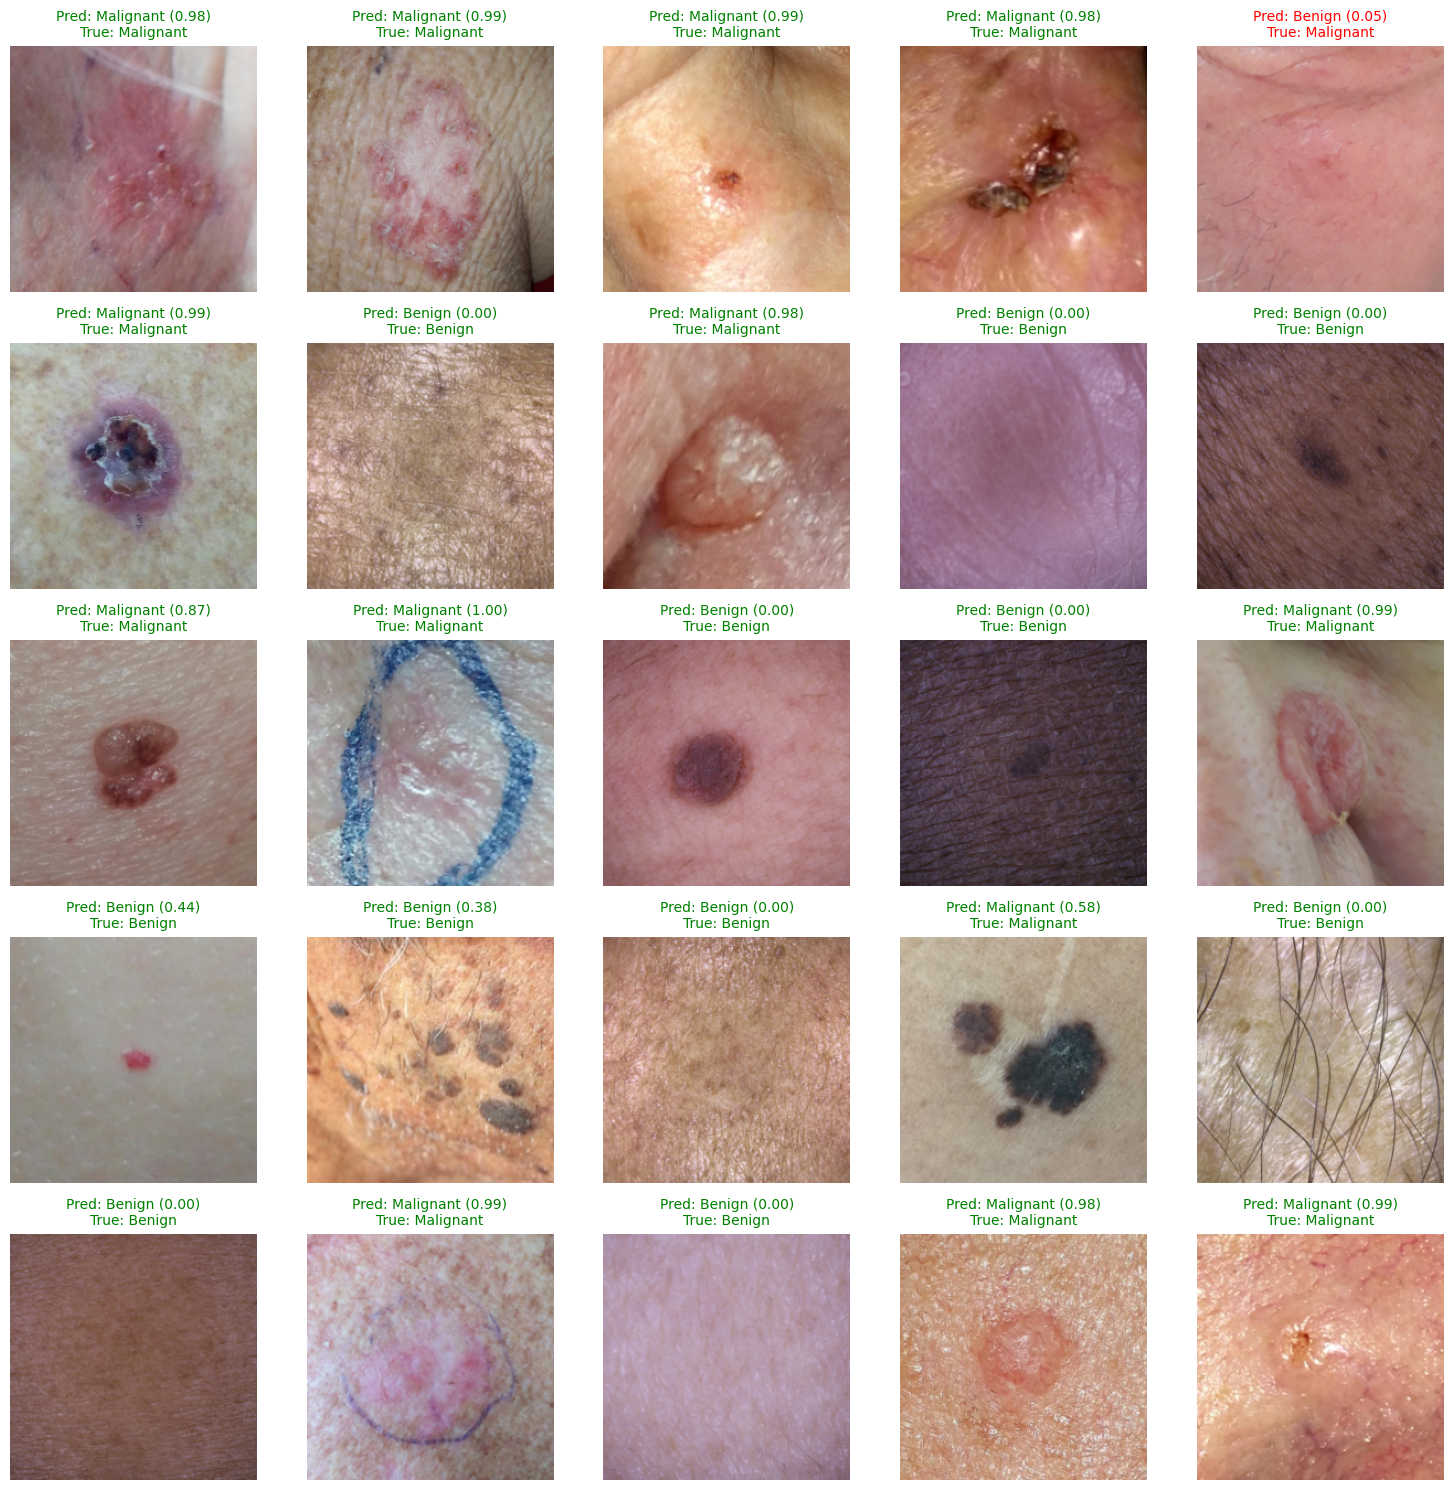

In [7]:
viz.show_predictions(results)

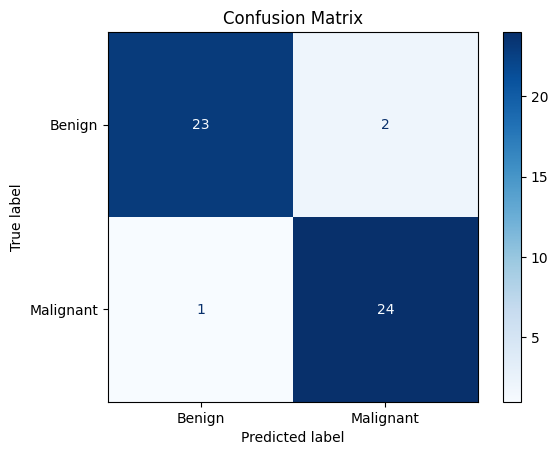

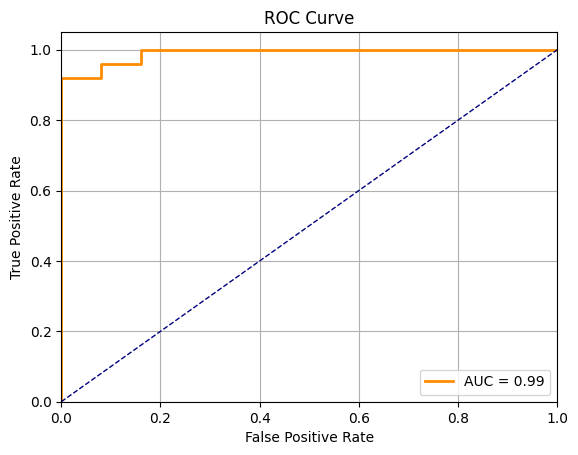

In [9]:
viz.plot_confusion_matrix(results["preds"], results["labels"])
viz.plot_auc_curve(results["probs"], results["labels"])